In [14]:
# Importando as bibliotecas necessárias
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [15]:
# Download do dataset MNIST into data dir
! wget https://pjreddie.com/media/files/mnist_train.csv -P data

--2025-01-05 21:59:42--  https://pjreddie.com/media/files/mnist_train.csv
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109575994 (104M) [text/csv]
Saving to: ‘data/mnist_train.csv.1’

mnist_train.csv.1   100%[===================>] 104.50M  32.8MB/s    in 3.5s    

2025-01-05 21:59:46 (29.6 MB/s) - ‘data/mnist_train.csv.1’ saved [109575994/109575994]



In [16]:
class MNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file, header=None)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # A primeira coluna é o rótulo
        label = self.data.iloc[idx, 0]
        # As demais colunas são os pixels da imagem
        image = self.data.iloc[idx, 1:].values.astype('uint8').reshape(28, 28)

        if self.transform:
            image = self.transform(image)

        return image, label

In [17]:
# Transformação para converter a imagem para tensor
transform = transforms.Compose([
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

# Criando o dataset
mnist_dataset = MNISTDataset("./data/mnist_train.csv", transform=transform)

# Transformação para converter a imagem para tensor
transform = transforms.Compose([
    transforms.ToPILImage(),    # Convertendo o array numpy para imagem PIL
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

# Criando o dataset
mnist_dataset = MNISTDataset("./data/mnist_train.csv", transform=transform)

In [18]:
# Criando índices aleatórios para os subsets de treino e teste
np.random.seed(42)
indices = np.arange(len(mnist_dataset))
np.random.shuffle(indices)

# Dividindo os índices em trainset e testset
num_train = 1000
num_val = 500
num_test = 500
train_indices = indices[:num_train]  # Primeiros 1.000 índices para o trainset
val_indices = indices[num_train:num_train+num_val]  # Próximos 500 índices para o valset
test_indices = indices[num_train+num_val:num_train+num_val+num_test]  # Mais 500 para o testset

trainset = Subset(mnist_dataset, train_indices)
valset = Subset(mnist_dataset, val_indices)
testset = Subset(mnist_dataset, test_indices)

# Criando DataLoaders para os subsets
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

In [19]:
def train_model(model, trainloader, valloader, criterion, optimizer, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

In [20]:
class CNN(nn.Module):
    def __init__(self, initialize_weights=True, dropout=0.2, num_filters_conv1=6,num_filters_conv2=12, num_hidden=64):
        super(CNN, self).__init__()
        self.num_filters_conv1 = num_filters_conv1
        self.num_filters_conv2 = num_filters_conv2
        self.conv1 = nn.Conv2d(1, num_filters_conv1, 5)
        self.conv2 = nn.Conv2d(num_filters_conv1, num_filters_conv2, 5)
        self.fc1 = nn.Linear(num_filters_conv2 * 4 * 4, num_hidden)
        self.fc2 = nn.Linear(num_hidden, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, self.num_filters_conv2 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [21]:
model = CNN(
    initialize_weights=True,
    dropout=0.2
)

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [23]:
# Treinando a CNN
history = train_model(
    model=model,
    trainloader=trainloader,
    valloader=valloader,
    criterion=criterion,
    optimizer=optimizer
)

100%|██████████| 16/16 [00:00<00:00, 19.67it/s]


Epoch 1, Train Loss: 2.279, Train Accuracy: 16.30%
Epoch 1, Val Loss: 2.213, Val Accuracy: 25.60%


100%|██████████| 16/16 [00:00<00:00, 17.65it/s]


Epoch 2, Train Loss: 2.096, Train Accuracy: 29.20%
Epoch 2, Val Loss: 1.862, Val Accuracy: 47.40%


100%|██████████| 16/16 [00:01<00:00, 14.16it/s]


Epoch 3, Train Loss: 1.559, Train Accuracy: 49.00%
Epoch 3, Val Loss: 1.080, Val Accuracy: 68.20%


100%|██████████| 16/16 [00:01<00:00, 10.72it/s]


Epoch 4, Train Loss: 0.957, Train Accuracy: 67.20%
Epoch 4, Val Loss: 0.684, Val Accuracy: 79.20%


100%|██████████| 16/16 [00:01<00:00, 13.78it/s]


Epoch 5, Train Loss: 0.643, Train Accuracy: 78.30%
Epoch 5, Val Loss: 0.484, Val Accuracy: 85.80%
Treinamento concluído


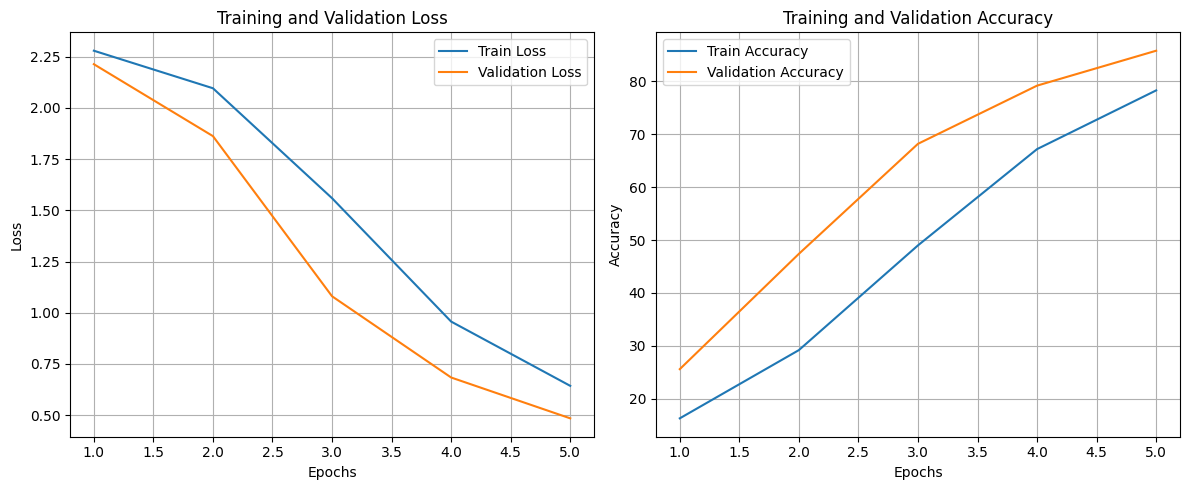

In [24]:
epochs = range(1, len(history['train_losses']) + 1)

# Plot de losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.grid()
plt.plot(epochs, history['train_losses'], label='Train Loss')
plt.plot(epochs, history['val_losses'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot de accuracies
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(epochs, history['train_accuracies'], label='Train Accuracy')
plt.plot(epochs, history['val_accuracies'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
test_model(model, testloader)

Acurácia da rede na base de teste: 87.00%


## Exercícios

### Exercício 1
Na CNN implementada, execute experimentos variando:
- O número de filtros convolucionais em `self.conv1` (6 e 8)
- O número de filtros convolucionais em `self.conv2` (12 e 16)

Ao final, observe qual combinação desempenha melhor no conjunto de testes.

Dica: Adicionar argumentos no construtor da classe para determinar o número de filtros em cada camada pode ser útil para inicializar diversos modelos.

In [26]:
parameters_combinations = [
    (6,12),
    (6,16),
    (8,12),
    (8,16)
]

for num_filters_conv1, num_filters_conv2 in parameters_combinations:
    print('                                                           ')
    print(f'Número de filtros em conv1: {num_filters_conv1}')
    print(f'Número de filtros em conv2: {num_filters_conv2}')
    model = CNN(
        initialize_weights=True,
        dropout=0.2,
        num_filters_conv1=8,
        num_filters_conv2=16
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    # Treinando a CNN
    history = train_model(
        model=model,
        trainloader=trainloader,
        valloader=valloader,
        criterion=criterion,
        optimizer=optimizer
    )

                                                           
Número de filtros em conv1: 6
Número de filtros em conv2: 12


100%|██████████| 16/16 [00:00<00:00, 17.36it/s]


Epoch 1, Train Loss: 2.222, Train Accuracy: 22.80%
Epoch 1, Val Loss: 2.033, Val Accuracy: 40.20%


100%|██████████| 16/16 [00:00<00:00, 16.24it/s]


Epoch 2, Train Loss: 1.721, Train Accuracy: 46.70%
Epoch 2, Val Loss: 1.225, Val Accuracy: 58.80%


100%|██████████| 16/16 [00:01<00:00, 11.05it/s]


Epoch 3, Train Loss: 0.901, Train Accuracy: 69.40%
Epoch 3, Val Loss: 0.608, Val Accuracy: 81.00%


100%|██████████| 16/16 [00:00<00:00, 21.04it/s]


Epoch 4, Train Loss: 0.606, Train Accuracy: 81.50%
Epoch 4, Val Loss: 0.489, Val Accuracy: 83.60%


100%|██████████| 16/16 [00:00<00:00, 20.93it/s]


Epoch 5, Train Loss: 0.370, Train Accuracy: 89.20%
Epoch 5, Val Loss: 0.362, Val Accuracy: 89.20%
Treinamento concluído
                                                           
Número de filtros em conv1: 6
Número de filtros em conv2: 16


100%|██████████| 16/16 [00:00<00:00, 21.10it/s]


Epoch 1, Train Loss: 2.279, Train Accuracy: 16.70%
Epoch 1, Val Loss: 2.139, Val Accuracy: 33.80%


100%|██████████| 16/16 [00:00<00:00, 17.14it/s]


Epoch 2, Train Loss: 1.876, Train Accuracy: 42.50%
Epoch 2, Val Loss: 1.370, Val Accuracy: 64.20%


100%|██████████| 16/16 [00:01<00:00, 15.59it/s]


Epoch 3, Train Loss: 1.153, Train Accuracy: 61.20%
Epoch 3, Val Loss: 0.830, Val Accuracy: 70.80%


100%|██████████| 16/16 [00:01<00:00, 14.24it/s]


Epoch 4, Train Loss: 0.755, Train Accuracy: 76.10%
Epoch 4, Val Loss: 0.583, Val Accuracy: 80.20%


100%|██████████| 16/16 [00:00<00:00, 16.61it/s]


Epoch 5, Train Loss: 0.540, Train Accuracy: 81.70%
Epoch 5, Val Loss: 0.432, Val Accuracy: 85.40%
Treinamento concluído
                                                           
Número de filtros em conv1: 8
Número de filtros em conv2: 12


100%|██████████| 16/16 [00:00<00:00, 21.00it/s]


Epoch 1, Train Loss: 2.239, Train Accuracy: 17.70%
Epoch 1, Val Loss: 2.062, Val Accuracy: 41.40%


100%|██████████| 16/16 [00:00<00:00, 20.92it/s]


Epoch 2, Train Loss: 1.752, Train Accuracy: 44.20%
Epoch 2, Val Loss: 1.220, Val Accuracy: 69.00%


100%|██████████| 16/16 [00:00<00:00, 20.71it/s]


Epoch 3, Train Loss: 0.986, Train Accuracy: 66.20%
Epoch 3, Val Loss: 0.594, Val Accuracy: 82.20%


100%|██████████| 16/16 [00:00<00:00, 21.01it/s]


Epoch 4, Train Loss: 0.621, Train Accuracy: 77.80%
Epoch 4, Val Loss: 0.452, Val Accuracy: 87.20%


100%|██████████| 16/16 [00:00<00:00, 21.15it/s]


Epoch 5, Train Loss: 0.436, Train Accuracy: 85.70%
Epoch 5, Val Loss: 0.391, Val Accuracy: 89.20%
Treinamento concluído
                                                           
Número de filtros em conv1: 8
Número de filtros em conv2: 16


100%|██████████| 16/16 [00:00<00:00, 21.03it/s]


Epoch 1, Train Loss: 2.250, Train Accuracy: 17.40%
Epoch 1, Val Loss: 2.133, Val Accuracy: 36.80%


100%|██████████| 16/16 [00:00<00:00, 21.55it/s]


Epoch 2, Train Loss: 1.881, Train Accuracy: 41.60%
Epoch 2, Val Loss: 1.330, Val Accuracy: 70.00%


100%|██████████| 16/16 [00:00<00:00, 20.43it/s]


Epoch 3, Train Loss: 0.970, Train Accuracy: 70.30%
Epoch 3, Val Loss: 0.554, Val Accuracy: 81.20%


100%|██████████| 16/16 [00:00<00:00, 17.07it/s]


Epoch 4, Train Loss: 0.531, Train Accuracy: 84.00%
Epoch 4, Val Loss: 0.401, Val Accuracy: 87.60%


100%|██████████| 16/16 [00:01<00:00, 15.06it/s]


Epoch 5, Train Loss: 0.370, Train Accuracy: 88.00%
Epoch 5, Val Loss: 0.321, Val Accuracy: 89.80%
Treinamento concluído


### Exercício 2

Na CNN implementada, execute 5 treinamentos variando aleatoriamente o número de neurônios de saída em `self.fc1` (o valor atual é 64 e também deve ser alterado na entrada da próxima camada).

Como você determinaria qual foi o melhor valor?

In [27]:
for i in range(5):
    num_neurons = np.random.randint(10, 100)
    model = CNN(
    initialize_weights=True,
    dropout=0.2,
    num_hidden=num_neurons
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    # Treinando a CNN
    history = train_model(
        model=model,
        trainloader=trainloader,
        valloader=valloader,
        criterion=criterion,
        optimizer=optimizer
    )

    print(f'num_hidden={num_neurons}')
    test_model(model, testloader)
    print()
    print()

100%|██████████| 16/16 [00:01<00:00, 14.74it/s]


Epoch 1, Train Loss: 2.301, Train Accuracy: 14.60%
Epoch 1, Val Loss: 2.230, Val Accuracy: 25.40%


100%|██████████| 16/16 [00:00<00:00, 18.35it/s]


Epoch 2, Train Loss: 2.131, Train Accuracy: 27.30%
Epoch 2, Val Loss: 1.894, Val Accuracy: 45.20%


100%|██████████| 16/16 [00:00<00:00, 21.26it/s]


Epoch 3, Train Loss: 1.629, Train Accuracy: 46.70%
Epoch 3, Val Loss: 1.100, Val Accuracy: 69.40%


100%|██████████| 16/16 [00:00<00:00, 20.90it/s]


Epoch 4, Train Loss: 0.958, Train Accuracy: 67.70%
Epoch 4, Val Loss: 0.611, Val Accuracy: 80.80%


100%|██████████| 16/16 [00:00<00:00, 20.96it/s]


Epoch 5, Train Loss: 0.662, Train Accuracy: 78.50%
Epoch 5, Val Loss: 0.481, Val Accuracy: 84.60%
Treinamento concluído
num_hidden=55
Acurácia da rede na base de teste: 83.80%




100%|██████████| 16/16 [00:00<00:00, 22.48it/s]


Epoch 1, Train Loss: 2.246, Train Accuracy: 17.50%
Epoch 1, Val Loss: 2.114, Val Accuracy: 29.60%


100%|██████████| 16/16 [00:00<00:00, 22.07it/s]


Epoch 2, Train Loss: 1.858, Train Accuracy: 40.00%
Epoch 2, Val Loss: 1.373, Val Accuracy: 60.40%


100%|██████████| 16/16 [00:00<00:00, 21.56it/s]


Epoch 3, Train Loss: 1.060, Train Accuracy: 66.10%
Epoch 3, Val Loss: 0.639, Val Accuracy: 78.00%


100%|██████████| 16/16 [00:00<00:00, 21.19it/s]


Epoch 4, Train Loss: 0.625, Train Accuracy: 79.60%
Epoch 4, Val Loss: 0.416, Val Accuracy: 86.60%


100%|██████████| 16/16 [00:00<00:00, 21.37it/s]


Epoch 5, Train Loss: 0.456, Train Accuracy: 84.80%
Epoch 5, Val Loss: 0.369, Val Accuracy: 89.20%
Treinamento concluído
num_hidden=78
Acurácia da rede na base de teste: 88.60%




100%|██████████| 16/16 [00:01<00:00, 14.91it/s]


Epoch 1, Train Loss: 2.249, Train Accuracy: 19.30%
Epoch 1, Val Loss: 2.067, Val Accuracy: 43.60%


100%|██████████| 16/16 [00:01<00:00, 15.65it/s]


Epoch 2, Train Loss: 1.739, Train Accuracy: 42.60%
Epoch 2, Val Loss: 1.088, Val Accuracy: 66.20%


100%|██████████| 16/16 [00:01<00:00, 14.90it/s]


Epoch 3, Train Loss: 0.967, Train Accuracy: 67.40%
Epoch 3, Val Loss: 0.605, Val Accuracy: 81.40%


100%|██████████| 16/16 [00:00<00:00, 21.63it/s]


Epoch 4, Train Loss: 0.580, Train Accuracy: 79.80%
Epoch 4, Val Loss: 0.406, Val Accuracy: 87.00%


100%|██████████| 16/16 [00:00<00:00, 21.85it/s]


Epoch 5, Train Loss: 0.396, Train Accuracy: 87.60%
Epoch 5, Val Loss: 0.421, Val Accuracy: 86.20%
Treinamento concluído
num_hidden=90
Acurácia da rede na base de teste: 87.40%




100%|██████████| 16/16 [00:00<00:00, 22.07it/s]


Epoch 1, Train Loss: 2.272, Train Accuracy: 16.30%
Epoch 1, Val Loss: 2.127, Val Accuracy: 34.60%


100%|██████████| 16/16 [00:00<00:00, 20.91it/s]


Epoch 2, Train Loss: 1.903, Train Accuracy: 40.10%
Epoch 2, Val Loss: 1.471, Val Accuracy: 53.80%


100%|██████████| 16/16 [00:00<00:00, 21.21it/s]


Epoch 3, Train Loss: 1.236, Train Accuracy: 57.80%
Epoch 3, Val Loss: 0.783, Val Accuracy: 76.00%


100%|██████████| 16/16 [00:00<00:00, 21.41it/s]


Epoch 4, Train Loss: 0.752, Train Accuracy: 74.60%
Epoch 4, Val Loss: 0.483, Val Accuracy: 85.80%


100%|██████████| 16/16 [00:00<00:00, 21.43it/s]


Epoch 5, Train Loss: 0.496, Train Accuracy: 82.70%
Epoch 5, Val Loss: 0.430, Val Accuracy: 87.40%
Treinamento concluído
num_hidden=61
Acurácia da rede na base de teste: 86.20%




100%|██████████| 16/16 [00:00<00:00, 21.52it/s]


Epoch 1, Train Loss: 2.265, Train Accuracy: 17.50%
Epoch 1, Val Loss: 2.140, Val Accuracy: 25.40%


100%|██████████| 16/16 [00:00<00:00, 21.22it/s]


Epoch 2, Train Loss: 1.959, Train Accuracy: 33.00%
Epoch 2, Val Loss: 1.589, Val Accuracy: 57.20%


100%|██████████| 16/16 [00:01<00:00, 15.95it/s]


Epoch 3, Train Loss: 1.355, Train Accuracy: 56.90%
Epoch 3, Val Loss: 0.865, Val Accuracy: 73.00%


100%|██████████| 16/16 [00:01<00:00, 15.07it/s]


Epoch 4, Train Loss: 0.919, Train Accuracy: 69.10%
Epoch 4, Val Loss: 0.608, Val Accuracy: 83.20%


100%|██████████| 16/16 [00:01<00:00, 14.94it/s]


Epoch 5, Train Loss: 0.701, Train Accuracy: 75.90%
Epoch 5, Val Loss: 0.468, Val Accuracy: 86.80%
Treinamento concluído
num_hidden=20
Acurácia da rede na base de teste: 85.40%


